# Imports

In [116]:
import keras
import datasets
import numpy as np
import transformers
import sklearn.metrics
import tensorflow as tf
import keras.backend as K
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from collections.abc import Callable

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

# Dataset

Load the dataset (we will be using [go_emotions](https://huggingface.co/datasets/google-research-datasets/go_emotions)). Pretokenize data or make a loader that tokenizes the sentenses as you iterate through the dataset. Implement two datasets: variable and fixed sentence length (in tokens). Don't forget to split the dataset into train and test subsets

In [3]:
dataset = datasets.load_dataset('google-research-datasets/go_emotions', name='raw', split='train')

Using the latest cached version of the dataset since google-research-datasets/go_emotions couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'raw' at /Users/danilapastuhov/.cache/huggingface/datasets/google-research-datasets___go_emotions/raw/0.0.0/add492243ff905527e67aeb8b80c082af02207c3 (last modified on Sat Oct 11 23:14:53 2025).


In [4]:
dataset

Dataset({
    features: ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
    num_rows: 211225
})

In [5]:
print(dataset.column_names)
# или
print(dataset[0])

['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
{'text': 'That game hurt.', 'id': 'eew5j0j', 'author': 'Brdd9', 'subreddit': 'nrl', 'link_id': 't3_ajis4z', 'parent_id': 't1_eew18eq', 'created_utc': 1548381056.0, 'rater_id': 1, 'example_very_unclear': False, 'admiration': 0, 'amusement': 0, 'anger': 0, 'annoyance': 0, 'approval': 0, 'caring': 0, 'confusion': 0, 'curiosity': 0, 'desire': 0, 'disappointment': 0, 'disapproval': 0, 'disgust': 0, 'embarrassment': 0, 'excitement': 0, 'fear': 0, 'gratitude': 0, 'grief': 0, 'joy': 0, 'love': 0, 'nervousness': 0, 'optimism': 0, 'pride': 0, 'realization': 

In [6]:
emotions = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
    'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
    'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]

In [7]:
y = np.array([[x[emotion] for emotion in emotions] for x in dataset])
texts = [x['text'] for x in dataset]

In [8]:
texts[3], emotions[y[3].argmax()]

('Man I love reddit.', 'love')

In [117]:
tokenizer = transformers.AutoTokenizer.from_pretrained('gpt2')# , use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

При простой токинизации появляется предупреждение 

```Token indices sequence length is longer than the specified maximum sequence length for this model (1435 > 1024). Running this sequence through the model will result in indexing errors```


```Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.```

Так мы узнали максимальную длину последовательности (max = 1435)

In [10]:
sizes = []
for text in dataset['text']:
    sizes.append(len(tokenizer(text, max_length=1435, truncation=True)['input_ids']))

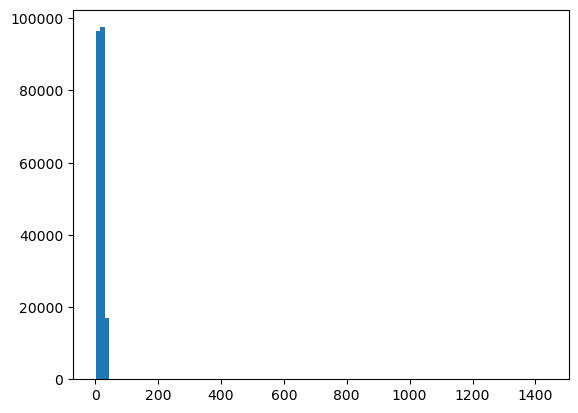

In [11]:
_ = plt.hist(sizes, bins=100)

In [12]:
len([i for i in sizes if i > 35]), (len([i for i in sizes if i > 35]) / len(sizes)) * 100

(1749, 0.8280269854420642)

In [13]:
# пример с максимальным количеством символов
texts[np.array(sizes).argmax()]

'For your kindness to mobile users I give a platinum ⠀⠀⠀⠀⠀⣤⣶⣶⡶⠦⠴⠶⠶⠶⠶⡶⠶⠦⠶⠶⠶⠶⠶⠶⠶⣄⠀⠀⠀⠀ ⠀⠀⠀⠀⠀⣿⣀⣀⣀⣀⠀⢀⣤⠄⠀⠀⣶⢤⣄⠀⠀⠀⣤⣤⣄⣿⠀⠀⠀⠀ ⠀⠀⠀⠀⠀⠿⣿⣿⣿⣿⡷⠋⠁⠀⠀⠀⠙⠢⠙⠻⣿⡿⠿⠿⠫⠋⠀⠀⠀⠀ ⠀⠀⠀⠀⠀⠀⢀⣤⠞⠉⠀⠀⠀⠀⣴⣶⣄⠀⠀⠀⢀⣕⠦⣀⠀⠀⠀⠀⠀⠀ ⠀⠀⠀⢀⣤⠾⠋⠁⠀⠀⠀⠀⢀⣼⣿⠟⢿⣆⠀⢠⡟⠉⠉⠊⠳⢤⣀⠀⠀⠀ ⠀⣠⡾⠛⠁⠀⠀⠀⠀⠀⢀⣀⣾⣿⠃⠀⡀⠹⣧⣘⠀⠀⠀⠀⠀⠀⠉⠳⢤⡀ ⠀⣿⡀⠀⠀⢠⣶⣶⣿⣿⣿⣿⡿⠁⠀⣼⠃⠀⢹⣿⣿⣿⣶⣶⣤⠀⠀⠀⢰⣷ ⠀⢿⣇⠀⠀⠈⠻⡟⠛⠋⠉⠉⠀⠀⡼⠃⠀⢠⣿⠋⠉⠉⠛⠛⠋⠀⢀⢀⣿⡏ ⠀⠘⣿⡄⠀⠀⠀⠈⠢⡀⠀⠀⠀⡼⠁⠀⢠⣿⠇⠀⠀⡀⠀⠀⠀⠀⡜⣼⡿⠀ ⠀⠀⢻⣷⠀⠀⠀⠀⠀⢸⡄⠀⢰⠃⠀⠀⣾⡟⠀⠀⠸⡇⠀⠀⠀⢰⢧⣿⠃⠀ ⠀⠀⠘⣿⣇⠀⠀⠀⠀⣿⠇⠀⠇⠀⠀⣼⠟⠀⠀⠀⠀⣇⠀⠀⢀⡟⣾⡟⠀⠀ ⠀⠀⠀⢹⣿⡄⠀⠀⠀⣿⠀⣀⣠⠴⠚⠛⠶⣤⣀⠀⠀⢻⠀⢀⡾⣹⣿⠃⠀⠀ ⠀⠀⠀⠀⢿⣷⠀⠀⠀⠙⠊⠁⠀⢠⡆⠀⠀⠀⠉⠛⠓⠋⠀⠸⢣⣿⠏⠀⠀⠀ ⠀⠀⠀⠀⠘⣿⣷⣦⣤⣤⣄⣀⣀⣿⣤⣤⣤⣤⣤⣄⣀⣀⣀⣀⣾⡟⠀⠀⠀⠀ ⠀⠀⠀⠀⠀⢹⣿⣿⣿⣻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠁⠀⠀⠀⠀ ⠀⠀⠀⠀⠀⠀⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠃'

In [14]:
median_length = int(np.median(sizes))
median_length

17

In [15]:
mean_length = int(np.mean(sizes))
mean_length

17

In [16]:
int(np.quantile(sizes, 0.01)), int(np.quantile(sizes, 0.99))

(3, 35)

In [17]:
max_length = int(np.quantile(sizes, 0.99)) # np.max(sizes)
max_length

35

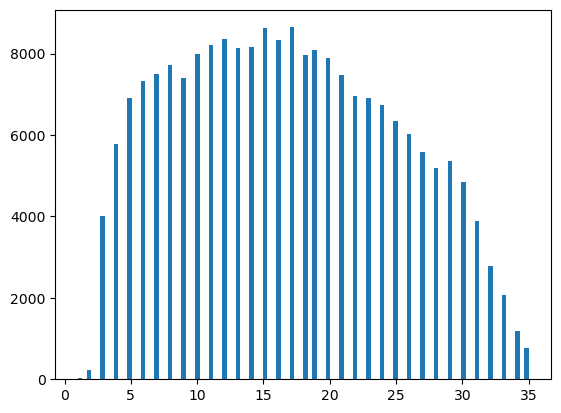

In [18]:
_ = plt.hist([x for x in sizes if x <= int(max_length)], bins=100)

In [19]:
count_ones = np.sum(y == 1, axis=0)

In [20]:
[{i: j} for i, j in zip(emotions, ((count_ones / len(y)) * 100).round(2))]

[{'admiration': 8.11},
 {'amusement': 4.38},
 {'anger': 3.83},
 {'annoyance': 6.45},
 {'approval': 8.34},
 {'caring': 2.84},
 {'confusion': 3.48},
 {'curiosity': 4.59},
 {'desire': 1.81},
 {'disappointment': 4.01},
 {'disapproval': 5.41},
 {'disgust': 2.51},
 {'embarrassment': 1.17},
 {'excitement': 2.66},
 {'fear': 1.51},
 {'gratitude': 5.5},
 {'grief': 0.32},
 {'joy': 3.78},
 {'love': 3.88},
 {'nervousness': 0.86},
 {'optimism': 4.13},
 {'pride': 0.62},
 {'realization': 4.16},
 {'relief': 0.61},
 {'remorse': 1.2},
 {'sadness': 3.2},
 {'surprise': 2.61},
 {'neutral': 26.18}]

In [21]:
# максимальное количество меток на один пример
np.sum(y == 1, axis=1).max()

12

In [22]:
# сам пример(
texts[np.sum(y == 1, axis=1).argmax()]

'Two or three anti depressants before I told them a lie about how I tried my moms valium and it worked'

In [23]:
[{i: j} for i, j in zip(emotions, y[np.sum(y == 1, axis=1).argmax(), :])]

[{'admiration': 1},
 {'amusement': 0},
 {'anger': 0},
 {'annoyance': 0},
 {'approval': 1},
 {'caring': 0},
 {'confusion': 0},
 {'curiosity': 1},
 {'desire': 0},
 {'disappointment': 1},
 {'disapproval': 0},
 {'disgust': 0},
 {'embarrassment': 1},
 {'excitement': 0},
 {'fear': 1},
 {'gratitude': 1},
 {'grief': 0},
 {'joy': 0},
 {'love': 0},
 {'nervousness': 1},
 {'optimism': 1},
 {'pride': 1},
 {'realization': 1},
 {'relief': 0},
 {'remorse': 1},
 {'sadness': 0},
 {'surprise': 0},
 {'neutral': 0}]

In [24]:
# количество не размеченных строк
idx = np.where(np.sum(y == 1, axis=1) == 0)[0]
len(idx)

3411

In [25]:
new_texts = np.delete(np.array(texts), idx)
new_y = np.delete(y, idx, axis=0)
len(new_texts), len(new_y)

(207814, 207814)

In [26]:
# разбиваем датасет
X_train, X_temp, y_train, y_temp = train_test_split(new_texts, new_y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [27]:
X_test

array(["[NAME] bless [NAME] for unlocking Michigan's Anger-Swag.",
       'Just remember I love you', 'Thank you, that is interesting!', ...,
       'bored waiting for the game [NAME]',
       'She looks just like that dude from Santa Clarita Diet',
       "Wow that's amazing, I hope my situation is as good next year. "],
      dtype='<U703')

In [28]:
# y_train
count_ones = np.sum(y_train == 1, axis=0)
[{i: j} for i, j in zip(emotions, ((count_ones / len(y)) * 100).round(2))]

[{'admiration': 6.49},
 {'amusement': 3.53},
 {'anger': 3.03},
 {'annoyance': 5.14},
 {'approval': 6.66},
 {'caring': 2.28},
 {'confusion': 2.78},
 {'curiosity': 3.65},
 {'desire': 1.42},
 {'disappointment': 3.23},
 {'disapproval': 4.31},
 {'disgust': 1.99},
 {'embarrassment': 0.93},
 {'excitement': 2.13},
 {'fear': 1.22},
 {'gratitude': 4.4},
 {'grief': 0.25},
 {'joy': 3.01},
 {'love': 3.09},
 {'nervousness': 0.69},
 {'optimism': 3.31},
 {'pride': 0.49},
 {'realization': 3.32},
 {'relief': 0.48},
 {'remorse': 0.97},
 {'sadness': 2.54},
 {'surprise': 2.09},
 {'neutral': 21.0}]

In [29]:
# y_val
count_ones = np.sum(y_val == 1, axis=0)
[{i: j} for i, j in zip(emotions, ((count_ones / len(y)) * 100).round(2))]

[{'admiration': 0.81},
 {'amusement': 0.42},
 {'anger': 0.43},
 {'annoyance': 0.65},
 {'approval': 0.84},
 {'caring': 0.29},
 {'confusion': 0.36},
 {'curiosity': 0.46},
 {'desire': 0.19},
 {'disappointment': 0.39},
 {'disapproval': 0.57},
 {'disgust': 0.26},
 {'embarrassment': 0.12},
 {'excitement': 0.28},
 {'fear': 0.15},
 {'gratitude': 0.54},
 {'grief': 0.03},
 {'joy': 0.38},
 {'love': 0.4},
 {'nervousness': 0.09},
 {'optimism': 0.42},
 {'pride': 0.06},
 {'realization': 0.4},
 {'relief': 0.06},
 {'remorse': 0.11},
 {'sadness': 0.33},
 {'surprise': 0.27},
 {'neutral': 2.57}]

In [30]:
# y_test
count_ones = np.sum(y_test == 1, axis=0)
[{i: j} for i, j in zip(emotions, ((count_ones / len(y)) * 100).round(2))]

[{'admiration': 0.81},
 {'amusement': 0.43},
 {'anger': 0.36},
 {'annoyance': 0.66},
 {'approval': 0.84},
 {'caring': 0.28},
 {'confusion': 0.35},
 {'curiosity': 0.47},
 {'desire': 0.19},
 {'disappointment': 0.4},
 {'disapproval': 0.53},
 {'disgust': 0.26},
 {'embarrassment': 0.12},
 {'excitement': 0.26},
 {'fear': 0.15},
 {'gratitude': 0.56},
 {'grief': 0.03},
 {'joy': 0.39},
 {'love': 0.39},
 {'nervousness': 0.08},
 {'optimism': 0.4},
 {'pride': 0.06},
 {'realization': 0.43},
 {'relief': 0.07},
 {'remorse': 0.12},
 {'sadness': 0.33},
 {'surprise': 0.26},
 {'neutral': 2.61}]

# Ограничение по токенам

In [31]:
X_train_tlimit = tokenizer(
    list(X_train),
    truncation=True,
    padding='max_length',
    max_length=median_length,
)['input_ids']

X_val_tlimit = tokenizer(
    list(X_val),
    truncation=True,
    padding='max_length',
    max_length=median_length,
)['input_ids']

X_test_tlimit = tokenizer(
    list(X_test),
    truncation=True,
    padding='max_length',
    max_length=median_length,
)['input_ids']

In [32]:
batch_size = 32
train_dataset_tlimit = tf.data.Dataset.from_tensor_slices((X_train_tlimit, y_train)).shuffle(10000).batch(batch_size)
val_dataset_tlimit = tf.data.Dataset.from_tensor_slices((X_val_tlimit, y_val)).batch(batch_size)
test_dataset_tlimit = tf.data.Dataset.from_tensor_slices((X_test_tlimit, y_test)).batch(batch_size)

# Нет ограничения по токенам

для этого токенизируем каждый батч отдельно до максимальной длины но не превышаем max_length

In [33]:
def batch_token(sentences, labels, tokenizer, num_classes, max_length=64, batch_size=32):
    """
    Создаёт tf.data.Dataset, в котором каждый батч:
    - токенизируется до максимальной длины в батче (но не больше max_length)
    - метки one-hot выравниваются по batch_size
    - возвращаются пары (X_batch, y_batch), готовые к model.fit()

    Параметры:
      sentences : list[str] — список предложений
      labels    : np.ndarray или list[np.ndarray] — one-hot метки (shape: (N, num_classes))
      tokenizer : HuggingFace токенайзер (или совместимый)
      num_classes : int — число классов
      max_length : int — глобальный предел длины
      batch_size : int — размер батча
    """

    # убедимся, что labels — numpy массив float32
    labels = np.array(labels, dtype=np.float32)

    def batch_generator(sentences, labels, batch_size, max_length):
        for i in range(0, len(sentences), batch_size):
            batch_sentences = sentences[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]

            # вычисляем длины предложений в батче
            lengths = [len(s.split()) if isinstance(s, str) else len(s) for s in batch_sentences]
            batch_max_len = min(max(lengths), max_length)

            # токенизация через HuggingFace tokenizer
            seqs = tokenizer(
                list(batch_sentences),
                truncation=True,
                padding='max_length',
                max_length=batch_max_len,
                return_tensors=None
            )['input_ids']

            # превращаем всё в тензоры
            X = tf.convert_to_tensor(seqs, dtype=tf.int32)
            y = tf.convert_to_tensor(batch_labels, dtype=tf.float32)

            yield X, y

    # создаём Dataset
    dataset = tf.data.Dataset.from_generator(
        lambda: batch_generator(sentences, labels, batch_size, max_length),
        output_signature=(
            tf.TensorSpec(shape=(None, None), dtype=tf.int32),     # X_batch
            tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)  # y_batch
        )
    )

    return dataset


In [34]:
train_dataset_maxt = batch_token(
                        X_train, 
                        y_train, 
                        tokenizer=tokenizer,
                        num_classes=28,
                        max_length=max_length, 
                        batch_size=32
                        ).repeat()

In [35]:
train_dataset_maxt.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, 28), dtype=tf.float32, name=None))>

In [36]:
val_dataset_maxt = batch_token(
                        X_val, 
                        y_val, 
                        tokenizer=tokenizer,
                        num_classes=28,
                        max_length=max_length, 
                        batch_size=32
                        ).repeat()

In [70]:
test_dataset_maxt = batch_token(
                        X_test, 
                        y_test, 
                        tokenizer=tokenizer,
                        num_classes=28,
                        max_length=max_length, 
                        batch_size=32
                        ).repeat()

In [38]:
y_train.shape

(166251, 28)

In [39]:
y_val.shape

(20781, 28)

# Model

Implement your model. The model should have the RNN architecture (with LSTM or GRU cells), support stacking and bidirectional feature extraction.

In [40]:
def get_name(prefix: str | None = None, suffix: str | None = None, separator: str = '_') -> str | None:
    return prefix and prefix + separator + suffix or suffix or None

In [41]:
import keras
from keras.layers import Input, Embedding, RNN, Bidirectional, Dense
from keras.models import Model

def get_model(
    units: int,
    n_tokens: int,
    n_labels: int,
    n_stacks: int = 1,
    bidirectional: bool = False,
    name: str | None = None,
    cell_type: type[keras.layers.Layer] = keras.layers.LSTMCell
) -> keras.Model:
    '''Creates a model with RNN architecture for sequence multilabel classification.
    Arguments:
        units: dimensionality of RNN cells
        n_tokens: number of tokens in the tokenizer dictionary
        n_labels: number of labels to be predicted
        n_stacks: number of RNN cells in the stack (1 -- no stacking)
        bidirectional: whether or not the model is bidirectional
        name: the model name
        cell_type: type of a cell to use, either keras.layers.LSTMCell or keras.layers.GRUCell
    Returns:
        The compiled keras.Model
    '''
    
    inputs = Input(shape=(None,), name='input', dtype='int32')
    x = Embedding(input_dim=n_tokens, output_dim=units, name='embedding')(inputs)
    
    # Create independent RNN cells
    cells = [cell_type(units) for _ in range(n_stacks)]
    rnn = RNN(keras.layers.StackedRNNCells(cells), return_sequences=False, name='rnn_stack')
    
    if bidirectional:
        rnn = Bidirectional(rnn, name='bidir_rnn_stack')
    
    x = rnn(x)
    outputs = Dense(n_labels, activation='sigmoid', name='predictions')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name=name)
    return model


In [42]:
# def get_model(
#     units: int,
#     n_tokens: int,
#     n_labels: int,
#     n_stacks: int = 1,
#     bidirectional: bool = False,
#     name: str | None = None,
#     cell_type: type[keras.layers.Layer] = keras.layers.LSTMCell
# ) -> keras.Model:
#     '''Creates a model with RNN architecture for sequence multilabel classification.
#     Arguments:
#         units: dimensionality of RNN cells
#         n_tokens: number of tokens in the tokenizer dictionary
#         n_labels: number of labels to be predicted
#         n_stacks: number of RNN cells in the stack (1 -- no stacking)
#         bidirectional: whether or not the model is bidirectional
#         name: the model name
#         cell_type: type of a cell to use, either keras.layers.LSTMCell or keras.layers.GRUCell
#     Returns:
#         The model'''

# Training

Train several models on the two dataset variants. Use either of the cell types (LSTM or GRU)
* Simple RNN (no stacking, one direction)
* Stacked RNN (stacking, one direction)
* Bidirectional RNN (no stacking, bidirectional)
* Stacked Bidirectional RNN (stacking, bidirectional)

In [43]:
# models = [
#     get_model(
#         units=...,
#         n_tokens=len(tokenizer.get_vocab()),
#         n_labels=len(emotions),
#         name=...,
#         bidirectional=...,
#         n_stacks=...,
#         cell_type=...
#     )
#     for ... in ...
# ]

models_tlimit = [
    get_model(
        units=32,
        n_tokens=len(tokenizer.get_vocab()),
        n_labels=len(emotions),
        n_stacks=n_stacks,
        bidirectional=bidirectional,
        name=f"tlimit_LSTM_{n_stacks}_{'bi' if bidirectional else 'uni'}",
        cell_type=keras.layers.LSTMCell
    )
    for n_stacks in [1, 2]
    for bidirectional in [False, True]
]

In [44]:
models_maxt = [
    get_model(
        units=32,
        n_tokens=len(tokenizer.get_vocab()),
        n_labels=len(emotions),
        n_stacks=n_stacks,
        bidirectional=bidirectional,
        name=f"maxt_LSTM_{n_stacks}_{'bi' if bidirectional else 'uni'}",
        cell_type=keras.layers.LSTMCell
    )
    for n_stacks in [1, 2]
    for bidirectional in [False, True]
]

Which loss should be used to multilabel classification? Which metrics?

Какие потери следует использовать для классификации по нескольким признакам? Какие показатели?

In [45]:
all_models = models_tlimit + models_maxt

In [46]:
for model in all_models:
    model.compile(
        loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
        
        # optimizer='adam',
        # loss='binary_crossentropy',
        # metrics=['accuracy']
        
        # loss='sparse_categorical_crossentropy', # "binary_crossentropy",
        #     optimizer="adam",
        # # optimizer=keras.optimizers.Adam(
        # #     ...
        # # ),
        # metrics=[
        #     "accuracy" # "binary_accuracy"
        # ]
    )

In [47]:
all_models[3].summary()


Model: "tlimit_LSTM_2_bi"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 32)       │     1,608,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidir_rnn_stack (Bidirectional) │ (None, 64)             │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,643,324 (6.27 MB)

 Trainable params: 1,643,324 (6.27 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# keras.utils.plot_model(all_models[-1])

In [89]:
steps_per_epoch = len(X_train) // 32
validation_steps = len(X_val) // 32
test_steps = (len(X_test) // 32) + 1

In [50]:
for i, model in enumerate(all_models[:]):
    print(model.name)
    if i < 4:
        model.fit(
            train_dataset_tlimit,
            validation_data=val_dataset_tlimit,
            epochs=5
        )
    else:
        model.fit(
            train_dataset_maxt,
            validation_data=val_dataset_maxt,
            epochs=5,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps
            )

tlimit_LSTM_1_uni
Epoch 1/5
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - binary_accuracy: 0.9568 - loss: 0.1620 - val_binary_accuracy: 0.9569 - val_loss: 0.1557
Epoch 2/5
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - binary_accuracy: 0.9585 - loss: 0.1415 - val_binary_accuracy: 0.9589 - val_loss: 0.1355
Epoch 3/5
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - binary_accuracy: 0.9605 - loss: 0.1274 - val_binary_accuracy: 0.9598 - val_loss: 0.1288
Epoch 4/5
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - binary_accuracy: 0.9617 - loss: 0.1196 - val_binary_accuracy: 0.9600 - val_loss: 0.1271
Epoch 5/5
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - binary_accuracy: 0.9625 - loss: 0.1144 - val_binary_accuracy: 0.9597 - val_loss: 0.1271
tlimit_LSTM_1_bi
Epoch 1/5
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - binary_accuracy: 0.9575 - loss: 0.1524 - val_binary_accuracy: 0.9589 - val_loss: 0.1387
Epoch 2/5
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - binary_accuracy: 0.9600 - loss: 0.1299 - val_

In [90]:
for i, model in enumerate(all_models):
    print(model.name)
    if i < 4:
        model.evaluate(test_dataset_tlimit)
    else:
        model.evaluate(test_dataset_maxt,
                        steps=test_steps)

tlimit_LSTM_1_uni
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - binary_accuracy: 0.9600 - loss: 0.1259
tlimit_LSTM_1_bi
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - binary_accuracy: 0.9599 - loss: 0.1261
tlimit_LSTM_2_uni
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - binary_accuracy: 0.9602 - loss: 0.1260
tlimit_LSTM_2_bi
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.9598 - loss: 0.1251
maxt_LSTM_1_uni
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - binary_accuracy: 0.9604 - loss: 0.1235
maxt_LSTM_1_bi
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.9603 - loss: 0.1227 
maxt_LSTM_2_uni
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.9604 - loss: 0.1243
maxt_LSTM_2_bi
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9606 - loss: 0.1229


In [78]:
for model in all_models:
    model.save(f"lstm/{model.name}.keras")

# Evaluation

Evaluate the models you trained on the test datasets. Plot ROC curves for each label (use `sklearn.metrics.RocCurveDisplay`) for each model.

Оцените модели, которые вы обучили на тестовых наборах данных. Постройте ROC-кривые для каждой метки (используйте `sklearn.metrics.RocCurveDisplay`) для каждой модели.

Plot the mean ROC AUC scores. Which model has the highest score? On what kind of dataset?

Выведите на график средние значения ROC AUC. У какой модели самый высокий балл? На каком наборе данных?

In [91]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from tensorflow.keras.preprocessing.sequence import pad_sequences

def plot_roc_curve(
    X: np.ndarray,
    y: np.ndarray,
    model: keras.Model,
    length: int,
    steps: int = 0,
    ax: plt.Axes | None = None
) -> float:
    '''Plots ROC curves for each of the labels (on a single axes) and outputs mean ROC AUC score.
    Arguments:
        X: model inputs - raw token sequences as list of lists or np.ndarray of lists
        y: ground truths (shape: samples, n_labels with 0/1) as np.ndarray
        model: model to plot the curve for
        ax: axes to plot on
    Returns:
        Mean ROC AUC score'''
    
    # Шаг 1: Pad'инг последовательностей (предполагаем, что max_length определён ранее)
    # X может быть list или np.object, pad_sequences справится
    # X_padded = pad_sequences(X, maxlen=length, padding='post', truncating='post', value=0)
    # value=0 для mask_zero=True в Embedding
    
    # Предсказания вероятностей
    y_pred_proba = model.predict(X, steps=steps)  # Shape: (samples, n_labels)
    
    # # Проверки
    # if y_pred_proba.shape != y.shape:
    #     raise ValueError(f"Shape mismatch: y_pred {y_pred_proba.shape} vs y {y.shape}")
    
    n_labels = y.shape[1]
    mean_auc = 0.0
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    for label_idx in range(n_labels):
        y_true_label = y[:, label_idx]
        y_pred_label = y_pred_proba[:, label_idx]
        
        fpr, tpr, _ = roc_curve(y_true_label, y_pred_label)
        roc_auc = auc(fpr, tpr)
        mean_auc += roc_auc
        
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=emotions[label_idx])
        display.plot(ax=ax, alpha=0.8, lw=1)
    
    mean_auc /= n_labels
    
    ax.set_title(f'ROC Curves (mean AUC = {mean_auc:.3f})')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    ax.grid(True)
    
    if ax.get_figure() is not None:
        plt.tight_layout()
    
    return mean_auc

Evaluating model: tlimit_LSTM_1_uni
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step
Evaluating model: tlimit_LSTM_1_bi
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step
Evaluating model: tlimit_LSTM_2_uni
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
Evaluating model: tlimit_LSTM_2_bi
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Evaluating model: maxt_LSTM_1_uni
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step
Evaluating model: maxt_LSTM_1_bi
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Evaluating model: maxt_LSTM_2_uni
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Evaluating model: maxt_LSTM_2_bi
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


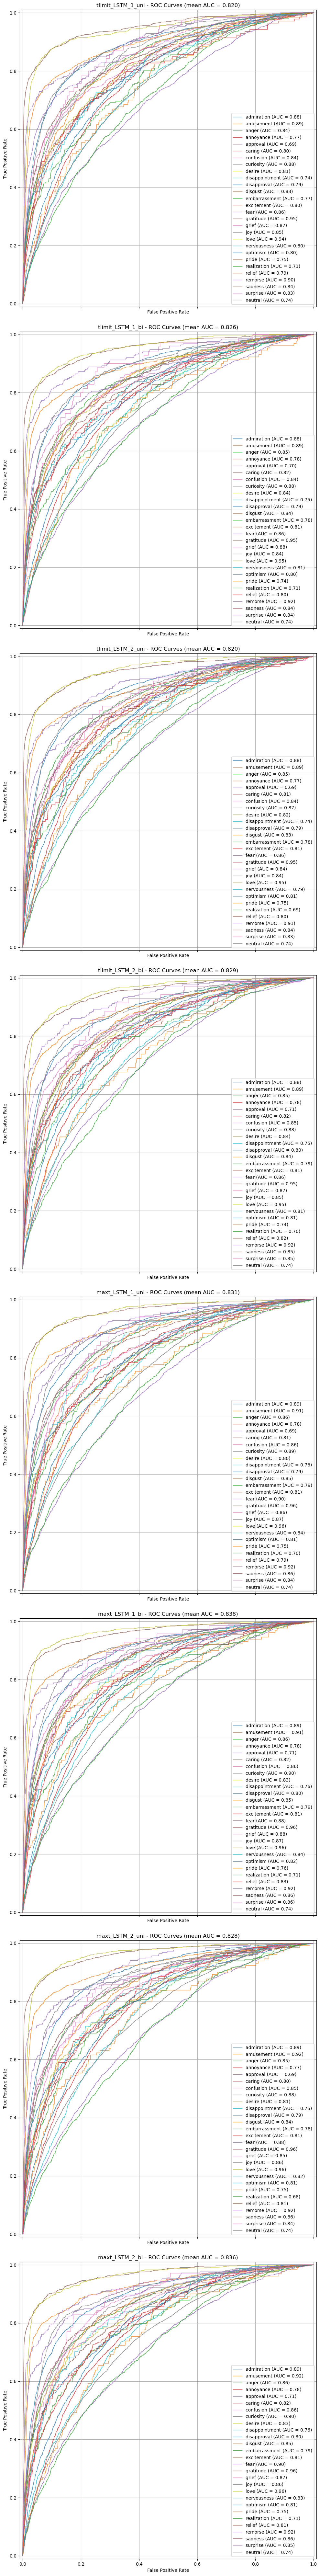

tlimit_LSTM_1_uni: Mean ROC AUC = 0.820
tlimit_LSTM_1_bi: Mean ROC AUC = 0.826
tlimit_LSTM_2_uni: Mean ROC AUC = 0.820
tlimit_LSTM_2_bi: Mean ROC AUC = 0.829
maxt_LSTM_1_uni: Mean ROC AUC = 0.831
maxt_LSTM_1_bi: Mean ROC AUC = 0.838
maxt_LSTM_2_uni: Mean ROC AUC = 0.828
maxt_LSTM_2_bi: Mean ROC AUC = 0.836


In [92]:
fig, axs = plt.subplots(len(all_models), 1, figsize=(10, 10 * len(all_models)), sharex=True)
if len(models_tlimit) == 1:
    axs = [axs]

mean_aucs = []
for idx, model in enumerate(all_models):
    print(f"Evaluating model: {model.name}")
                
    mean_auc = plot_roc_curve(
        (test_dataset_tlimit if idx < 4 else test_dataset_maxt), 
        y_test, 
        model, 
        median_length, 
        steps=(0 if idx < 4 else test_steps), 
        ax=axs[idx]
    )
    mean_aucs.append(mean_auc)
    axs[idx].set_title(f'{model.name} - ROC Curves (mean AUC = {mean_auc:.3f})')

plt.tight_layout()
plt.show()

for name, auc_score in zip([m.name for m in all_models], mean_aucs):
    print(f"{name}: Mean ROC AUC = {auc_score:.3f}")


# Inspect the best model performance closer. Come up with some sentences (in English). Does the model output sensible results?

Внимательно изучите наилучшие характеристики модели. Напишите несколько предложений (на английском языке). Дает ли модель разумные результаты?

For each of your texts get a list of emotion labels and plot emotion scores

Для каждого из ваших текстов получите список эмоциональных меток и оцените их по шкале

In [99]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support
# --- Анализ лучшей модели ---
# Предполагаем, что models и mean_aucs из предыдущего кода
# Находим лучшую по mean ROC AUC
best_idx = np.argmax(mean_aucs)
best_model = all_models[best_idx]
best_auc = mean_aucs[best_idx]
print(f"Best model: {best_model.name} with mean ROC AUC = {best_auc:.3f}")


y_pred_proba = best_model.predict(
                            (test_dataset_tlimit if best_idx < 4 else test_dataset_maxt), 
                            steps=(0 if best_idx < 4 else test_steps)
                            )
y_pred_binary = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report (per label):")
# emotions - list of label names
report = classification_report(y_test, y_pred_binary, target_names=emotions, digits=3, zero_division=0)
print(report)

# ROC AUC per label
auc_per_label = []
for i in range(y_test.shape[1]):
    auc_label = roc_auc_score(y_test[:, i], y_pred_proba[:, i])
    auc_per_label.append(auc_label)
    print(f"{emotions[i]} AUC: {auc_label:.3f}")

# Precision, Recall, F1 macro
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_binary, average='macro', zero_division=0)
print(f"\nMacro Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")

# Micro AUC
micro_auc = roc_auc_score(y_test, y_pred_proba, average='micro')
print(f"Micro ROC AUC: {micro_auc:.3f}")

Best model: maxt_LSTM_1_bi with mean ROC AUC = 0.838
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Classification Report (per label):
                precision    recall  f1-score   support

    admiration      0.608     0.408     0.488      1721
     amusement      0.600     0.416     0.491       902
         anger      0.479     0.149     0.228       763
     annoyance      0.571     0.003     0.006      1385
      approval      0.496     0.038     0.070      1777
        caring      0.484     0.053     0.095       587
     confusion      0.627     0.043     0.081       736
     curiosity      0.552     0.111     0.184      1003
        desire      0.706     0.058     0.108       411
disappointment      1.000     0.001     0.002       836
   disapproval      0.346     0.056     0.096      1125
       disgust      0.530     0.095     0.162       555
 embarrassment      0.833     0.019     0.037       263
    excitement      0.565     0.064     0.114       550
          fear      0.563    

In [103]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import keras

def label_text(
    text: list[str],
    model: keras.Model,
    threshold: float = 0.5,
    max_length: int = 64,
    steps: int = 0
) -> list[list[str]]:
    """
    Computes the model output for `text` and outputs a list of emotions
    that have a probability of at least `threshold`.
    
    Arguments:
        text: list of strings to label
        model: trained Keras model with attributes `tokenizer` and `labels`
        threshold: probability threshold
        max_length: max length for tokenization
        
    Returns:
        List of lists of predicted emotion labels (one list per input text)
    """

    text = tokenizer(
                test_sentences,
                truncation=True,
                padding='max_length',
                max_length=max_length
                )['input_ids']

    padded = pad_sequences(text, maxlen=max_length, padding='post', truncating='post')
    
    # Предсказание
    probs = model.predict(padded, steps=steps)
    
    # Преобразование в список меток по порогу
    predictions = []
    for prob_vector in probs:
        labels_above_threshold = [
            label for label, p in zip(emotions, prob_vector) if p >= threshold
        ]
        predictions.append(labels_above_threshold)
    
    return predictions


In [104]:
test_sentences = [
    "I am so happy today because I won the lottery!", # joy
    "I feel really sad and lonely after the breakup.",  # sadness
    "This horror movie scared me to death!",  # fear
    "I am furious at the customer service for this mistake!",  # anger
    "What a wonderful surprise party!",  # surprise, joy
    "I love spending time with my family on weekends.",  # love
    "The news of the accident shocked everyone.",  # sadness, fear
    "I achieved my goal after years of hard work.",  # joy, pride (if in emotions)
    "This is the best day of my life!",  # joy
    "I can't believe how disappointing this outcome is."  # sadness, anger
]

preds = label_text(text, 
                   best_model, 
                   threshold=0.2, 
                   max_length=(median_length if best_idx < 4 else max_length),
                  steps=test_steps)
for i, j in zip(test_sentences, preds):
    print(i, j)
    print()

650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step   
I am so happy today because I won the lottery! ['excitement', 'joy']

I feel really sad and lonely after the breakup. ['sadness']

This horror movie scared me to death! ['disappointment', 'fear', 'nervousness']

I am furious at the customer service for this mistake! ['disappointment']

What a wonderful surprise party! ['admiration', 'excitement', 'surprise']

I love spending time with my family on weekends. ['love']

The news of the accident shocked everyone. ['excitement', 'surprise', 'neutral']

I achieved my goal after years of hard work. []

This is the best day of my life! ['admiration']

I can't believe how disappointing this outcome is. ['disappointment']



/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


# Bonus

Train and evaluate the same model as your best one, but use a different cell type

Тренируйте и оценивайте ту же модель, что и ваша лучшая, но используйте другой тип ячеек

In [58]:
gru_models_tlimit = [
    get_model(
        units=32,
        n_tokens=len(tokenizer.get_vocab()),
        n_labels=len(emotions),
        n_stacks=n_stacks,
        bidirectional=bidirectional,
        name=f"tlimit_GRU_{n_stacks}_{'bi' if bidirectional else 'uni'}",
        cell_type=keras.layers.GRUCell
    )
    for n_stacks in [1, 2]
    for bidirectional in [False, True]
]

In [59]:
gru_models_maxt = [
    get_model(
        units=32,
        n_tokens=len(tokenizer.get_vocab()),
        n_labels=len(emotions),
        n_stacks=n_stacks,
        bidirectional=bidirectional,
        name=f"maxt_GRU_{n_stacks}_{'bi' if bidirectional else 'uni'}",
        cell_type=keras.layers.GRUCell
    )
    for n_stacks in [1, 2]
    for bidirectional in [False, True]
]

Which loss should be used to multilabel classification? Which metrics?

Какие потери следует использовать для классификации по нескольким признакам? Какие показатели?

In [60]:
gru_all_models = gru_models_tlimit + gru_models_maxt

In [61]:
for model in gru_all_models:
    model.compile(
        loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
        # loss="binary_crossentropy",
        #     optimizer="adam",
        # # optimizer=keras.optimizers.Adam(
        # #     ...
        # # ),
        # metrics=[
        #     "accuracy"
        # ]
    )

In [62]:
gru_all_models[0].summary()


Model: "tlimit_GRU_1_uni"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 32)       │     1,608,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_stack (RNN)                 │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 28)             │           924 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,615,484 (6.16 MB)

 Trainable params: 1,615,484 (6.16 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# keras.utils.plot_model(gru_all_models[-1])

In [64]:
for i, model in enumerate(gru_all_models):
    print(model.name)
    if i < 4:
        model.fit(
            train_dataset_tlimit,
            validation_data=val_dataset_tlimit,
            epochs=5
        )
    else:
        model.fit(
            train_dataset_maxt,
            validation_data=val_dataset_maxt,
            epochs=5,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps
        )

tlimit_GRU_1_uni
Epoch 1/5
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - binary_accuracy: 0.9572 - loss: 0.1544 - val_binary_accuracy: 0.9588 - val_loss: 0.1381
Epoch 2/5
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - binary_accuracy: 0.9601 - loss: 0.1295 - val_binary_accuracy: 0.9597 - val_loss: 0.1290
Epoch 3/5
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - binary_accuracy: 0.9614 - loss: 0.1203 - val_binary_accuracy: 0.9598 - val_loss: 0.1265
Epoch 4/5
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - binary_accuracy: 0.9623 - loss: 0.1146 - val_binary_accuracy: 0.9598 - val_loss: 0.1265
Epoch 5/5
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - binary_accuracy: 0.9629 - loss: 0.1105 - val_binary_accuracy: 0.9596 - val_loss: 0.1274
tlimit_GRU_1_bi
Epoch 1/5
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - binary_accuracy: 0.9584 - loss: 0.1440 - val_binary_accuracy: 0.9596 - val_loss: 0.1305
Epoch 2/5
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - binary_accuracy: 0.9609 - loss: 0.1232 - val_bi

In [109]:
for i, model in enumerate(gru_all_models):
    print(model.name)
    if i < 4:
        model.evaluate(test_dataset_tlimit)
    else:
        model.evaluate(test_dataset_maxt, steps=test_steps)

tlimit_GRU_1_uni
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - binary_accuracy: 0.9599 - loss: 0.1256
tlimit_GRU_1_bi
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - binary_accuracy: 0.9598 - loss: 0.1255
tlimit_GRU_2_uni
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - binary_accuracy: 0.9602 - loss: 0.1264
tlimit_GRU_2_bi
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.9593 - loss: 0.1259
maxt_GRU_1_uni
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - binary_accuracy: 0.9603 - loss: 0.1231
maxt_GRU_1_bi
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.9599 - loss: 0.1235
maxt_GRU_2_uni
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.9604 - loss: 0.1231
maxt_GRU_2_bi
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9601 - loss: 0.1235


In [66]:
for model in gru_all_models:
    model.save(f"gru/{model.name}.keras")

Evaluating model: tlimit_GRU_1_uni
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
Evaluating model: tlimit_GRU_1_bi
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step
Evaluating model: tlimit_GRU_2_uni
650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
Evaluating model: tlimit_GRU_2_bi
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Evaluating model: maxt_GRU_1_uni
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step
Evaluating model: maxt_GRU_1_bi
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Evaluating model: maxt_GRU_2_uni
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Evaluating model: maxt_GRU_2_bi
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


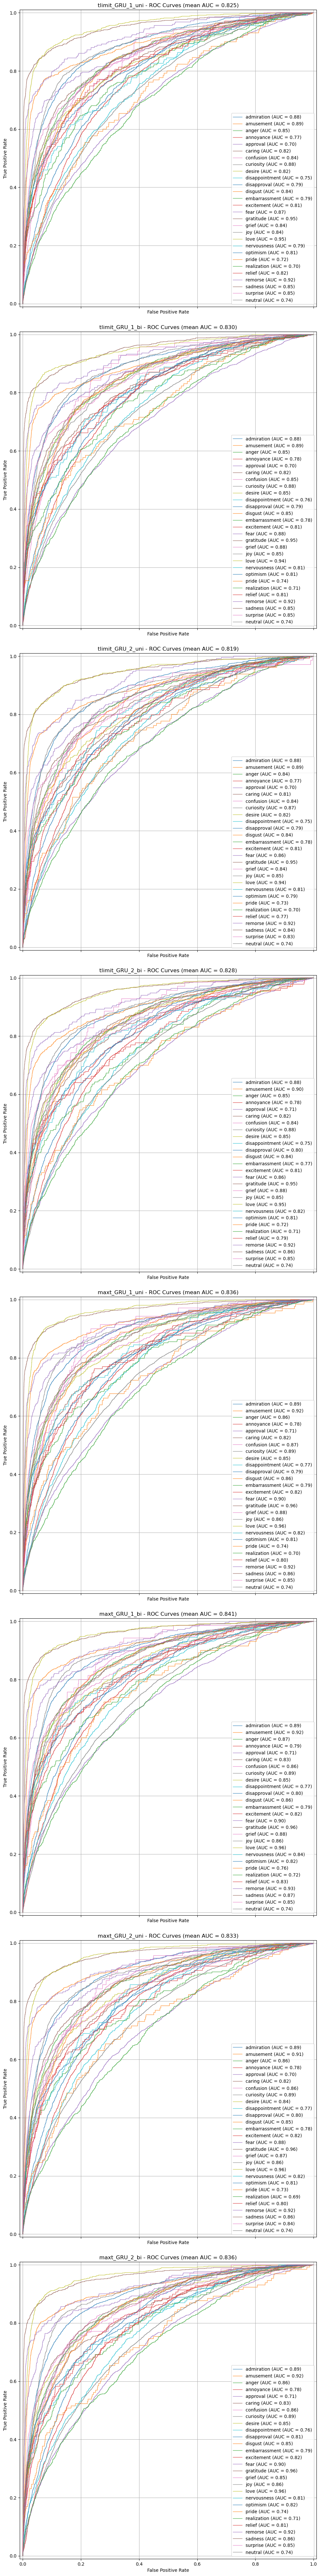

tlimit_GRU_1_uni: Mean ROC AUC = 0.825
tlimit_GRU_1_bi: Mean ROC AUC = 0.830
tlimit_GRU_2_uni: Mean ROC AUC = 0.819
tlimit_GRU_2_bi: Mean ROC AUC = 0.828
maxt_GRU_1_uni: Mean ROC AUC = 0.836
maxt_GRU_1_bi: Mean ROC AUC = 0.841
maxt_GRU_2_uni: Mean ROC AUC = 0.833
maxt_GRU_2_bi: Mean ROC AUC = 0.836


In [111]:
fig, axs = plt.subplots(len(gru_all_models), 1, figsize=(10, 10 * len(gru_all_models)), sharex=True)
if len(gru_models_tlimit) == 1:
    axs = [axs]

mean_aucs = []
for idx, model in enumerate(gru_all_models):
        print(f"Evaluating model: {model.name}")
                    
        mean_auc = plot_roc_curve(
            (test_dataset_tlimit if idx < 4 else test_dataset_maxt), 
            y_test, 
            model, 
            median_length, 
            steps=(0 if idx < 4 else test_steps),
            ax=axs[idx]
        )
        mean_aucs.append(mean_auc)
        axs[idx].set_title(f'{model.name} - ROC Curves (mean AUC = {mean_auc:.3f})')

plt.tight_layout()
plt.show()

for name, auc_score in zip([m.name for m in gru_all_models], mean_aucs):
    print(f"{name}: Mean ROC AUC = {auc_score:.3f}")

In [115]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support
# --- Анализ лучшей модели ---
# Предполагаем, что models и mean_aucs из предыдущего кода
# Находим лучшую по mean ROC AUC
best_idx = np.argmax(mean_aucs)
gru_best_model = gru_all_models[best_idx]
best_auc = mean_aucs[best_idx]
print(f"Best model: {best_model.name} with mean ROC AUC = {best_auc:.3f}")


y_pred_proba = gru_best_model.predict(
    (test_dataset_tlimit if best_idx < 4 else test_dataset_maxt),
    steps=(0 if idx < 4 else test_steps)
)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report (per label):")
# emotions - list of label names
report = classification_report(
                                y_test, 
                                y_pred_binary, 
                                target_names=emotions, 
                                digits=3, 
                                zero_division=0
                                )
print(report)

# ROC AUC per label
auc_per_label = []
for i in range(y_test.shape[1]):
    auc_label = roc_auc_score(y_test[:, i], y_pred_proba[:, i])
    auc_per_label.append(auc_label)
    print(f"{emotions[i]} AUC: {auc_label:.3f}")

# Precision, Recall, F1 macro
prec, rec, f1, _ = precision_recall_fscore_support(
                                                    y_test, y_pred_binary, 
                                                    average='macro', 
                                                    zero_division=0
                                                    )
print(f"\nMacro Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")

# Micro AUC
micro_auc = roc_auc_score(y_test, y_pred_proba, average='micro')
print(f"Micro ROC AUC: {micro_auc:.3f}")

Best model: maxt_LSTM_1_bi with mean ROC AUC = 0.841
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Classification Report (per label):
                precision    recall  f1-score   support

    admiration      0.585     0.433     0.498      1721
     amusement      0.606     0.426     0.500       902
         anger      0.439     0.165     0.240       763
     annoyance      0.333     0.012     0.022      1385
      approval      0.466     0.069     0.121      1777
        caring      0.494     0.066     0.117       587
     confusion      0.500     0.069     0.122       736
     curiosity      0.546     0.118     0.194      1003
        desire      0.475     0.068     0.119       411
disappointment      0.407     0.053     0.093       836
   disapproval      0.353     0.073     0.121      1125
       disgust      0.610     0.130     0.214       555
 embarrassment      0.636     0.080     0.142       263
    excitement      0.547     0.105     0.177       550
          fear      0.609    

In [69]:
test_sentences = [
    "I am so happy today because I won the lottery!", # joy
    "I feel really sad and lonely after the breakup.",  # sadness
    "This horror movie scared me to death!",  # fear
    "I am furious at the customer service for this mistake!",  # anger
    "What a wonderful surprise party!",  # surprise, joy
    "I love spending time with my family on weekends.",  # love
    "The news of the accident shocked everyone.",  # sadness, fear
    "I achieved my goal after years of hard work.",  # joy, pride (if in emotions)
    "This is the best day of my life!",  # joy
    "I can't believe how disappointing this outcome is."  # sadness, anger
]

preds = label_text(text, 
                   gru_best_model, 
                   threshold=0.2, 
                   max_length=(median_length if best_idx < 4 else max_length))
for i, j in zip(test_sentences, preds):
    print(i, j)
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
I am so happy today because I won the lottery! ['joy']

I feel really sad and lonely after the breakup. ['disappointment', 'sadness']

This horror movie scared me to death! ['fear', 'nervousness']

I am furious at the customer service for this mistake! ['disappointment', 'sadness']

What a wonderful surprise party! ['admiration', 'excitement', 'surprise']

I love spending time with my family on weekends. ['joy', 'love']

The news of the accident shocked everyone. ['surprise', 'neutral']

I achieved my goal after years of hard work. ['disappointment', 'sadness']

This is the best day of my life! ['admiration', 'joy']

I can't believe how disappointing this outcome is. ['disappointment']

